In [45]:
import qiskit
print(qiskit.__version__)


2.0.0


Step    1: Energy = -0.69327160, beta = -0.03424
Step  101: Energy = -0.73942460, beta = 0.00698
Step  201: Energy = -0.77298762, beta = 0.01483
Step  301: Energy = -0.77686351, beta = -0.00180
Step  401: Energy = -0.78043005, beta = 0.00919
Step  501: Energy = -0.78701441, beta = -0.01629
Step  601: Energy = -0.83543806, beta = -0.01595
Step  701: Energy = -0.84888578, beta = 0.02013
Step  801: Energy = -0.88763237, beta = 0.01144
Step  901: Energy = -0.89023647, beta = -0.00528
Step 1001: Energy = -0.89455996, beta = -0.00806
Step 1101: Energy = -0.90578630, beta = -0.01080
Step 1201: Energy = -0.90973083, beta = 0.00688
Step 1301: Energy = -0.93058833, beta = 0.01527
Step 1401: Energy = -0.93800672, beta = -0.00323
Step 1501: Energy = -0.94550274, beta = -0.00950
Step 1601: Energy = -0.95007899, beta = -0.00353
Step 1701: Energy = -0.95039153, beta = 0.00210
Step 1801: Energy = -0.95405943, beta = 0.00836
Step 1901: Energy = -0.95835420, beta = 0.00186
Step 2001: Energy = -0.9605980

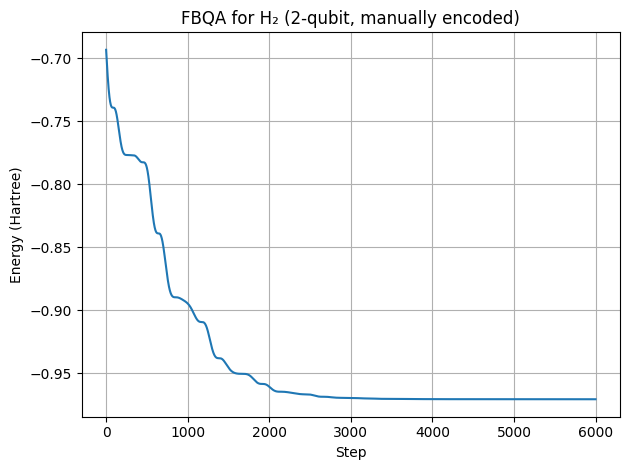

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

# Step 1: 手动定义 H2 的 2-qubit 哈密顿量（sto-3g 基组，0.74Å，Jordan-Wigner 后）
# 来源于 OpenFermion + PySCF + Jordan-Wigner 映射（精确到 1e-3）
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])

# Pauli tensor products
def kron(*args):
    out = args[0]
    for a in args[1:]:
        out = np.kron(out, a)
    return out

H = (
    -0.8126 * kron(I, I) +
    0.1712 * kron(Z, I) +
    0.1712 * kron(I, Z) +
    0.1686 * kron(Z, Z) +
    0.1205 * kron(X, X) +
    0.1205 * kron(Y, Y)
)

n_qubits = 2

# Step 2: Driver Hamiltonian H_d = -Y0 - Y1
H_d = - kron(Y, I) - kron(I, Y)

# Step 3: 初始态 |+>^2
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
psi = Statevector.from_instruction(qc).data

# Step 4: commutator 哈密顿量
comm = 1j * (H_d @ H - H @ H_d)

# Step 5: FBQA 主循环
def fbqa_run(H, H_d, comm, psi0, delta_t=0.05, steps=2000, eta=1.0):
    state = psi0
    betas = []
    energies = []

    for k in range(steps):
        beta_k = -eta * delta_t * np.vdot(state, comm @ state).real
        betas.append(beta_k)

        U_c = expm(-1j * H * delta_t)
        U_d = expm(-1j * H_d * beta_k * delta_t)
        state = U_d @ U_c @ state

        energy = np.vdot(state, H @ state).real
        energies.append(energy)

        if k % 100 == 0 or k == steps - 1:
            print(f"Step {k+1:4d}: Energy = {energy:.8f}, beta = {beta_k:.5f}")

    return energies, betas

# Step 6: 运行 FBQA
energies, betas = fbqa_run(H, H_d, comm, psi, delta_t=0.05, steps=6000, eta=1.0)

# Step 7: 可视化
plt.plot(energies)
plt.xlabel("Step")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA for H₂ (2-qubit, manually encoded)")
plt.grid(True)
plt.tight_layout()
plt.show()


Step    1: E = -0.69210000 Ha, β = -0.000000
Step  101: E = -0.82964850 Ha, β = 0.007467
Step  201: E = -0.84177869 Ha, β = 0.023347
Step  301: E = -0.89286195 Ha, β = -0.033516
Step  401: E = -0.94318419 Ha, β = 0.016528
Step  501: E = -0.95610943 Ha, β = 0.002031
Step  601: E = -0.96134619 Ha, β = -0.008286
Step  701: E = -0.96427310 Ha, β = 0.005699
Step  801: E = -0.96485670 Ha, β = -0.001827
Step  901: E = -0.96520582 Ha, β = -0.000066
Step 1001: E = -0.96546470 Ha, β = 0.000500
Step 1101: E = -0.96551383 Ha, β = -0.000543
Step 1201: E = -0.96552324 Ha, β = 0.000486
Step 1301: E = -0.96554026 Ha, β = -0.000276
Step 1401: E = -0.96554685 Ha, β = 0.000012
Step 1501: E = -0.96554788 Ha, β = 0.000131
Step 1601: E = -0.96554866 Ha, β = -0.000119
Step 1701: E = -0.96554901 Ha, β = 0.000045
Step 1801: E = -0.96554910 Ha, β = 0.000006
Step 1901: E = -0.96554915 Ha, β = -0.000018
Step 2000: E = -0.96554917 Ha, β = 0.000012


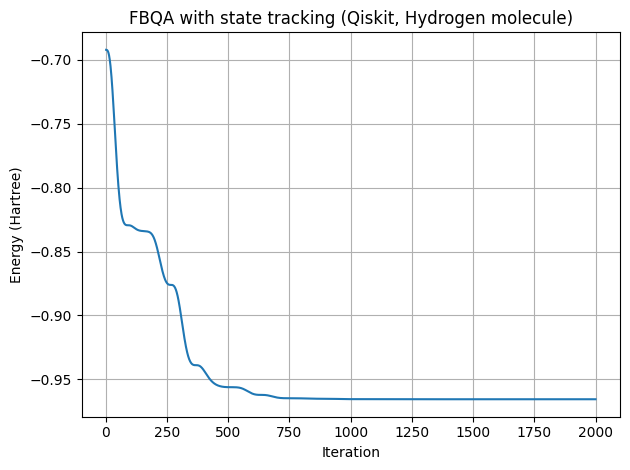

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Step 1: 手动定义 H2 分子的 qubit Hamiltonian（2-qubit）
# Jordan-Wigner 映射后，H2 (sto-3g, 0.74Å) 对应哈密顿量如下：
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)
Y = np.array([[0, -1j], [1j, 0]])

def kron(*args):
    out = args[0]
    for a in args[1:]:
        out = np.kron(out, a)
    return out

H_c = (
    -0.8126 * kron(I, I)
    + 0.1712 * kron(Z, I)
    + 0.1712 * kron(I, Z)
    + 0.1686 * kron(Z, Z)
    + 0.1205 * kron(X, X)
    + 0.1205 * kron(Y, Y)
)

n_qubits = 2

# Step 2: Driver Hamiltonian（与原PennyLane逻辑一致）
H_d = kron(X, I) + kron(I, X)

# Step 3: 构造 commutator 哈密顿量：i[Hd, Hc]
comm_h = 1j * (H_d @ H_c - H_c @ H_d)

# Step 4: 初始化量子态 |+>^n
qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.h(i)
psi = Statevector.from_instruction(qc).data

# Step 5: 单步演化矩阵构造
def single_falqon_unitary(beta_k, delta_t, H_cost, H_driver):
    U_c = expm(-1j * H_cost * delta_t)
    U_d = expm(-1j * H_driver * beta_k * delta_t)
    return U_d @ U_c

# Step 6: 测量期望值
def measure_expectation(state, H):
    return np.real(np.vdot(state, H @ state))

# Step 7: 主循环：FBQA状态跟踪
def run_fbqa_state_tracking(H, H_d, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    state = psi

    for i in range(n_steps):
        # feedback beta
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -1 * delta_t * exp_comm
        beta_list.append(next_beta)

        # apply unitary
        U_k = single_falqon_unitary(next_beta, delta_t, H, H_d)
        state = U_k @ state

        # measure energy
        energy = measure_expectation(state, H)
        energy_list.append(energy)

        if i % 100 == 0 or i == n_steps - 1:
            print(f"Step {i+1:4d}: E = {energy:.8f} Ha, β = {next_beta:.6f}")

    return beta_list, energy_list

# Step 8: 设置参数并运行
n_steps = 2000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(H_c, H_d, comm_h, n_steps, beta_1, delta_t)

# Step 9: 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA with state tracking (Qiskit, Hydrogen molecule)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

from openfermionpyscf import run_pyscf
from openfermion import MolecularData
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

# Step 1: 用 PySCF 构建 H₂ 分子 + 获取 Fermionic Hamiltonian
geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.74))]
basis = "sto-3g"
molecule = MolecularData(geometry, basis, multiplicity=1, charge=0)
molecule = run_pyscf(molecule, run_scf=True)
fermionic_ham = molecule.get_molecular_hamiltonian()

# Step 2: Jordan-Wigner 映射 → qubit Hamiltonian
qubit_ham = jordan_wigner(fermionic_ham)

# Step 3: 转为稀疏矩阵（scipy 格式）
H_c = get_sparse_operator(qubit_ham).toarray()
n_qubits = molecule.n_qubits
print(f"Qubit Hamiltonian matrix shape: {H_c.shape}")

# Step 4: 构造 driver Hamiltonian H_d = ∑ X_i
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
H_d = np.zeros_like(H_c)

def kron(*ops):
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result

for i in range(n_qubits):
    ops = [I] * n_qubits
    ops[i] = X
    H_d += kron(*ops)

# Step 5: 构造 commutator Hamiltonian
comm_h = 1j * (H_d @ H_c - H_c @ H_d)

# Step 6: 初始化 |+>^n 态
qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.h(i)
psi = Statevector.from_instruction(qc).data

# Step 7: 单步 FALQON 演化矩阵
def single_falqon_unitary(beta_k, delta_t, H_cost, H_driver):
    U_cost = expm(-1j * H_cost * delta_t)
    U_driver = expm(-1j * H_driver * beta_k * delta_t)
    return U_driver @ U_cost

# Step 8: 测量期望值
def measure_expectation(state, H):
    return np.real(np.vdot(state, H @ state))

# Step 9: 主流程：状态保留式 FBQA
def run_fbqa_state_tracking(H, H_d, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []
    state = psi

    for i in range(n_steps):
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -1 * delta_t * exp_comm
        beta_list.append(next_beta)

        U_k = single_falqon_unitary(next_beta, delta_t, H, H_d)
        state = U_k @ state

        energy = measure_expectation(state, H)
        energy_list.append(energy)

        if i % 100 == 0 or i == n_steps - 1:
            print(f"Step {i+1:4d}: E = {energy:.8f} Ha, β = {next_beta:.6f}")

    return beta_list, energy_list

# Step 10: 设置参数并运行
n_steps = 2000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(H_c, H_d, comm_h, n_steps, beta_1, delta_t)

# Step 11: 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA (H₂, PySCF + Qiskit, matrix-based)")
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: `np.string_` was removed in the NumPy 2.0 release. Use `np.bytes_` instead.

In [53]:
import numpy as np
print(np.__version__)  # ✅ 这次必须是 1.26.0


2.2.5
